# This file contains the tutorials for: 
- Mapping and projecting predictions from individual to stiched images
- Merging pointclouds from upper and lower lidars
- Projecting the merged pointclouds to the stiched image
- Projecting the merged pointclouds to the individual images
- Undistoring the images and projecting the pointclouds to the undistorted version

In [1]:

from os.path import join

import cv2
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import torch
import yaml
from numpy.linalg import inv

data_dir = "/mnt/SSD3TB/dataset/JRDB2022"
calibration_dir = "../calibration"

TRAIN = [
    'bytes-cafe-2019-02-07_0',
    'clark-center-2019-02-28_0',
    'clark-center-2019-02-28_1',
    'clark-center-intersection-2019-02-28_0',
    'cubberly-auditorium-2019-04-22_0',
    'forbes-cafe-2019-01-22_0',
    'gates-159-group-meeting-2019-04-03_0',
    'gates-ai-lab-2019-02-08_0',
    'gates-basement-elevators-2019-01-17_1',
    'gates-to-clark-2019-02-28_1',
    'hewlett-packard-intersection-2019-01-24_0',
    'huang-2-2019-01-25_0',
    'huang-basement-2019-01-25_0',
    'huang-lane-2019-02-12_0',
    'jordan-hall-2019-04-22_0',
    'memorial-court-2019-03-16_0',
    'meyer-green-2019-03-16_0',
    'nvidia-aud-2019-04-18_0',
    'packard-poster-session-2019-03-20_0',
    'packard-poster-session-2019-03-20_1',
    'packard-poster-session-2019-03-20_2',
    'stlc-111-2019-04-19_0',
    'svl-meeting-gates-2-2019-04-08_0',
    'svl-meeting-gates-2-2019-04-08_1',
    'tressider-2019-03-16_0',
    'tressider-2019-03-16_1',
    'tressider-2019-04-26_2'
]
TEST = [
    'cubberly-auditorium-2019-04-22_1',
    'discovery-walk-2019-02-28_0',
    'discovery-walk-2019-02-28_1',
    'food-trucks-2019-02-12_0',
    'gates-ai-lab-2019-04-17_0',
    'gates-basement-elevators-2019-01-17_0',
    'gates-foyer-2019-01-17_0',
    'gates-to-clark-2019-02-28_0',
    'hewlett-class-2019-01-23_0',
    'hewlett-class-2019-01-23_1',
    'huang-2-2019-01-25_1',
    'huang-intersection-2019-01-22_0',
    'indoor-coupa-cafe-2019-02-06_0',
    'lomita-serra-intersection-2019-01-30_0',
    'meyer-green-2019-03-16_1',
    'nvidia-aud-2019-01-25_0',
    'nvidia-aud-2019-04-18_1',
    'nvidia-aud-2019-04-18_2',
    'outdoor-coupa-cafe-2019-02-06_0',
    'quarry-road-2019-02-28_0',
    'serra-street-2019-01-30_0',
    'stlc-111-2019-04-19_1',
    'stlc-111-2019-04-19_2',
    'tressider-2019-03-16_2',
    'tressider-2019-04-26_0',
    'tressider-2019-04-26_1',
    'tressider-2019-04-26_3'
]


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Mapping and projecting predictions from individual to stiched images

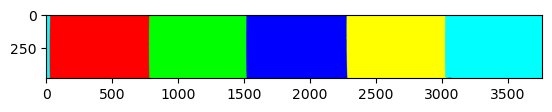

In [3]:
# Load calibration data
indi2stitched_mapping = {}
for cam_id in [0, 2, 4, 6, 8]:
    # the mapping here has shape (480, 752, 10), where 10 is the x and y coordinates of up to 5 matched points on stitched image
    # if there is  1 matched point,  the first 2 values are the coordinates of the matched point,  and the rest are -1
    # if there are 2 matched points, the first 4 values are the coordinates of the matched points, and the rest are -1
    # and so on
    indi2stitched_mapping[cam_id] = np.load(
        join(calibration_dir, "indi2stitch_mappings", f"indi2stitch_mapping_camera_{cam_id}.npy"))

stitched_image = np.zeros((480, 3760, 3), dtype=np.uint8)
# generate 5 images with 5 colors 
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]
for i, cam_id in enumerate([6, 8, 0, 2, 4]):
    img = np.zeros((480, 752, 3), dtype=np.uint8)
    img[:, :, :] = colors[i]

    yI, xI = np.indices((480, 752))  # get the y and x coordinates of the individual image
    yxS = indi2stitched_mapping[cam_id][yI, xI, :]  # get the matched points on the stitched image
    yxS = yxS[yxS != -1]  # remove the -1 values
    yS, xS = yxS[::2].astype(np.int32), yxS[1::2].astype(np.int32)  # get the y and x coordinates of the matched points
    stitched_image[yS, xS] = colors[
        i]  # fill the matched points on the stitched image with the color of the individual image

# visualize the stitched image
plt.imshow(stitched_image)  # Here we can see the 5 images are stitched together
# cv2.imshow("stitched_image", stitched_image)
# if cv2.waitKey(0) & 0xFF == ord('q'):
#     cv2.destroyAllWindows()



# Merging pointclouds from upper and lower lidars using newly released calibration data

In [4]:
location = 'stlc-111-2019-04-19_0'
lidar_config = join(calibration_dir, "lidars.yaml")
# Load calibration data
with open(lidar_config, 'r') as f:
    lidar_calib = yaml.safe_load(f)

# Load pointclouds    
lower_pcd = o3d.io.read_point_cloud(
    join(data_dir, 'train_dataset_with_activity', 'pointclouds', 'lower_velodyne', location, '000000.pcd')).points
upper_pcd = o3d.io.read_point_cloud(
    join(data_dir, 'train_dataset_with_activity', 'pointclouds', 'upper_velodyne', location, '000000.pcd')).points
# homogenize the points
upper_pcd = np.hstack([np.array(upper_pcd), np.ones((len(upper_pcd), 1))])
lower_pcd = np.hstack([np.array(lower_pcd), np.ones((len(lower_pcd), 1))])

lower2upper = np.array(lidar_calib["lidar"]["lower2upper"])
###### apply the transformation to the lower lidar ########
lower_pcd = np.dot(lower2upper, np.transpose(np.array(lower_pcd)))
# merge the pointclouds
merged_pcd = np.hstack([np.transpose(np.array(upper_pcd)), lower_pcd]).transpose()

# visualize the merged pointcloud
geo = o3d.geometry.PointCloud()
geo.points = o3d.utility.Vector3dVector(merged_pcd[:, :3])
o3d.visualization.draw_geometries([geo],
                                  front=[-0.6800824811170337, 0.41243405720855975, 0.6061237227927859],
                                  lookat=[4.065364327503271, 0.0051067110204547055, -0.5536299890783712],
                                  up=[0.467778086099835, -0.3924855099706242, 0.7919209472086702],
                                  zoom=0.08)






# Projecting the merged pointclouds to the stiched image

Assume that now we have the merged lidar pointclouds, we want to project the pointclouds to the stitched image.

In [5]:
def project_velo_to_ref(pointcloud):
    """
    Adjusts the coordinate system of a given point cloud to match that of the reference camera frame.
    
    This function assumes the input point cloud is in the Velodyne coordinate system, where the X axis points
    forward from the vehicle, the Y axis points to the left, and the Z axis points up. The function converts
    the point cloud to the reference camera coordinate system, where the X axis points to the right, the Y axis
    points down, and the Z axis points forward.
    
    Parameters:
    - pointcloud (numpy.ndarray): The input point cloud data in the Velodyne coordinate system.
    
    Returns:
    - numpy.ndarray: The point cloud adjusted to the reference camera coordinate system.
    """
    pointcloud = pointcloud[:, [1, 2, 0]]  # Swap the order of the axes to X->Y, Y->Z, Z->X
    pointcloud[:, 0] *= -1  # Invert X axis
    pointcloud[:, 1] *= -1  # Invert Y axis
    return pointcloud

def calculate_median_param_value(param):
    """
    Calculates the median value of a specified camera parameter across a subset of omni-directional camera sensors.
    
    This function is designed to extract a specific parameter (e.g., focal length in x/y, translation in x/y,
    skew coefficient) from the calibration data of omni-directional cameras and compute its median value. This
    is useful for operations that require a representative value of camera parameters across multiple sensors.
    
    Parameters:
    - param (str): The camera parameter to compute the median for. Acceptable values are 'f_y', 'f_x', 't_y', 't_x', 's'.
    
    Returns:
    - float: The median value of the specified parameter.
    
    Raises:
    - Exception: If an unrecognized parameter name is provided.
    """
    # Index mapping for each parameter within the calibration matrix
    if param == 'f_y':
        idx = 4
    elif param == 'f_x':
        idx = 0
    elif param == 't_y':
        idx = 5
    elif param == 't_x':
        idx = 2
    elif param == 's':
        idx = 1
    else:
        raise Exception('Wrong parameter!')

    omni_camera = ['sensor_0', 'sensor_2', 'sensor_4', 'sensor_6', 'sensor_8']  # Define omni-directional cameras
    parameter_list = []
    for sensor, camera_params in camera_calib['cameras'].items():
        if sensor not in omni_camera:
            continue
        K_matrix = camera_params['K'].split(' ')  # Extract calibration matrix
        parameter_list.append(float(K_matrix[idx]))
    return np.median(parameter_list)  # Compute and return the median of the parameters

def project_ref_to_image_torch(pointcloud):
    """
    Projects points from the reference camera coordinate system to the image plane using PyTorch.
    
    This function calculates the 2D coordinates of 3D points on the image plane, using the horizontal
    angle (theta) to determine the X coordinate and a combination of vertical position, angle, and
    precomputed camera parameters to determine the Y coordinate. It is specifically designed for
    panoramic image stitching.
    
    Parameters:
    - pointcloud (torch.Tensor): The input point cloud data in the reference camera coordinate system.
    
    Returns:
    - torch.Tensor: The 2D points on the image plane corresponding to the input 3D points.
    """
    # Compute the horizontal angle for each point
    theta = (torch.atan2(pointcloud[:, 0], pointcloud[:, 2]) + np.pi) % (2 * np.pi)
    horizontal_fraction = theta / (2 * np.pi)  # Normalize the angle to a fraction of the full circle
    x = (horizontal_fraction * img_shape[2]) % img_shape[2]  # Compute X coordinate in the image
    # Compute Y coordinate using vertical position, angle, and camera parameters
    y = -median_focal_length_y * (
            pointcloud[:, 1] * torch.cos(theta) / pointcloud[:, 2]) + median_optical_center_y
    pts_2d = torch.stack([x, y], dim=1)  # Stack X and Y coordinates to form 2D points
    return pts_2d


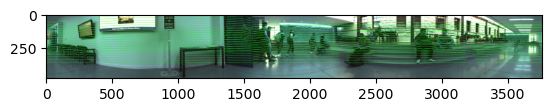

In [6]:
# load camera config
camera_config = join(calibration_dir, "cameras.yaml")
with open(camera_config, 'r') as f:
    camera_calib = yaml.safe_load(f)
image = cv2.imread(join(data_dir, 'train_dataset_with_activity', 'images', 'image_stitched', location, '000000.jpg'))

# Load the transformation matrix from upper LiDAR sensor to the ego vehicle frame
# This matrix is used to transform the point cloud coordinates from the LiDAR sensor's local frame to the vehicle's coordinate frame.
upper2ego = np.array(lidar_calib["lidar"]["upper2ego"])

# Transform the merged point clouds to the ego vehicle frame
# By applying the transformation matrix to the point cloud, we align the point cloud data with the vehicle's coordinate system.
ego_pcd = upper2ego.dot(merged_pcd.transpose()).transpose()

# Project the transformed point clouds to the reference frame (i.e., camera or stitched image frame)
# This is done by adjusting the coordinate system of the point cloud to match that of the camera frame, preparing it for projection onto the 2D image.
ref_pcd = project_velo_to_ref(ego_pcd)

# Define the image shape and compute necessary camera parameters for projection
# These parameters include the median focal length and optical center, which are critical for accurately mapping 3D points to 2D coordinates in the image plane.
img_shape = (3, 480, 3760)
median_focal_length_y = calculate_median_param_value('f_y')
median_optical_center_y = calculate_median_param_value('t_y')

# Project the reference frame point clouds onto the image plane using PyTorch
# This step converts 3D point cloud coordinates into 2D image coordinates, considering the camera's intrinsic parameters and the geometry of the projection.
pts_2d = project_ref_to_image_torch(torch.tensor(ref_pcd))

# Visualize the projected point clouds on the stitched panorama image
# Each point in the 2D projection is visualized as a small circle on the image, providing a visual representation of the point cloud's location in the scene.
for pts in pts_2d:
    x, y = pts
    cv2.circle(image, (int(x), int(y)), 1, (0, 255, 0), -1)

# Display the image with the projected points
# Uncomment the lines below to view the image in a window using OpenCV's imshow function. Close the window by pressing 'q'.
plt.imshow(image)  # This line uses Matplotlib to show the image within a notebook or a Python script.
# cv2.imshow("image", image)
# if cv2.waitKey(0) & 0xFF == ord('q'):
#     cv2.destroyAllWindows()







# Projecting the merged pointclouds to the individual images

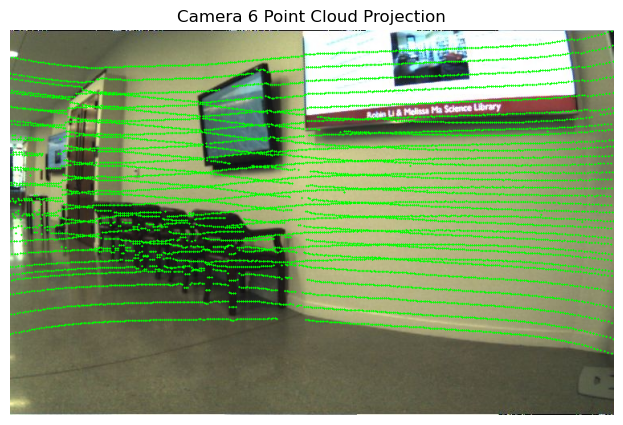

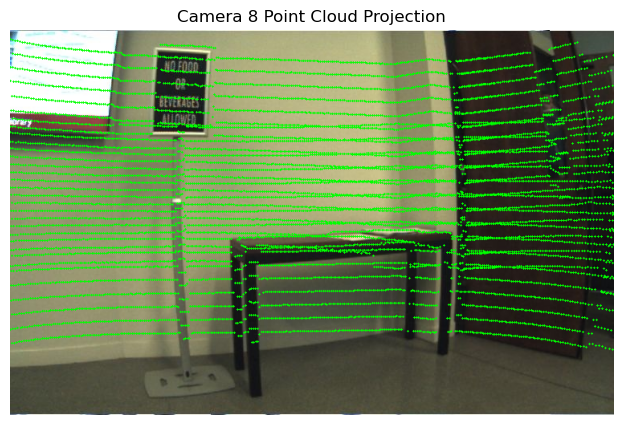

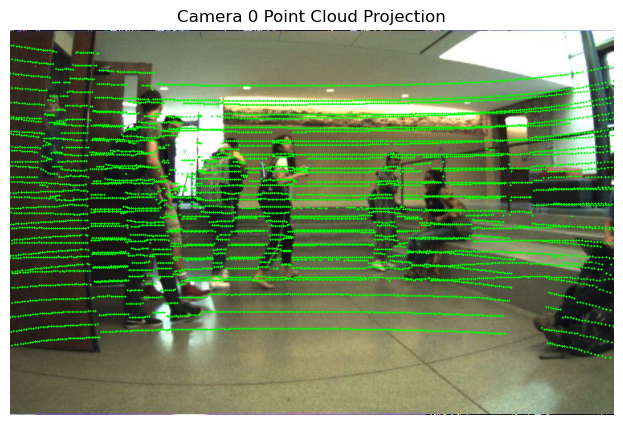

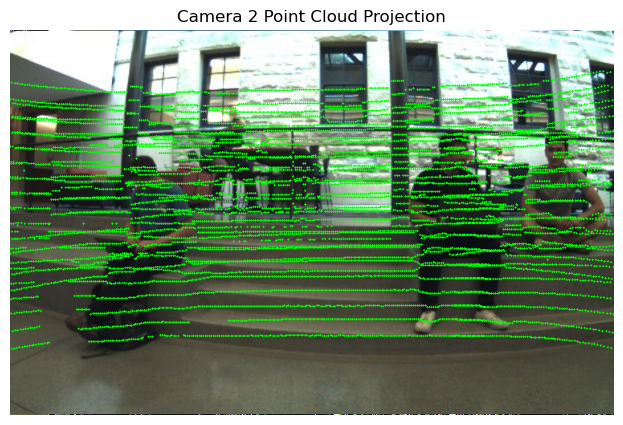

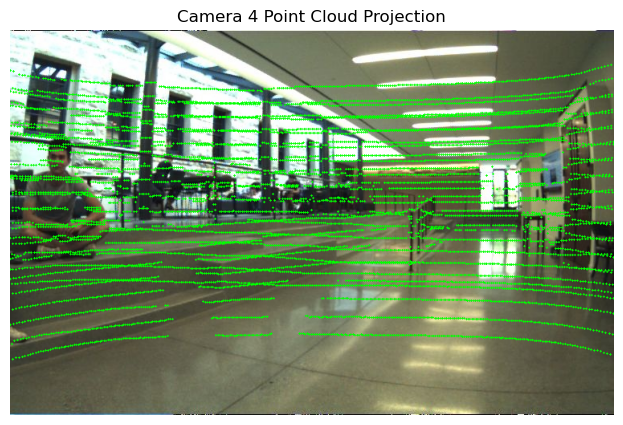

In [7]:
# Loop through each camera ID to process and visualize the point clouds as seen by the camera.
for cam_id in [6, 8, 0, 2, 4]:
    # Retrieve calibration data for the current camera.
    cam_calib = lidar_calib[f'sensor_{cam_id}']
    # Reshape and homogenize the intrinsic camera matrix K to prepare for projection calculations.
    K = np.array(cam_calib['distorted_img_K']).reshape(3, 3)
    K = np.hstack([K, np.zeros((3, 1))])  # Add a column of zeros to homogenize the K matrix.
    D = np.array(cam_calib['D'])  # Distortion coefficients.

    # Compute the transformation matrix from the LiDAR (upper) to the camera coordinate system.
    upper2ego = np.array(lidar_calib["lidar"]["upper2ego"])
    ego2cam = inv(np.array(cam_calib["cam2ego"]))
    pts_ref = ego2cam.dot(upper2ego.dot(merged_pcd.T)).T
    pts_ref = pts_ref[pts_ref[:, 2] > 0]  # Keep only points in front of the camera.

    # Normalize the points to the image plane.
    pts_ref = pts_ref[:, :2] / pts_ref[:, 2].reshape(-1, 1)

    # Apply radial distortion to the normalized points using the distortion coefficients.
    x, y = pts_ref[:, 0], pts_ref[:, 1]
    k1, k2, k3, k4, k5= D
    k6 = 0  # Assuming no 6th distortion coefficient.
    r2 = x ** 2 + y ** 2
    r4 = x ** 4 + y ** 4
    r6 = x ** 6 + y ** 6
    fx, _, cx, _ = K[0]
    _, fy, cy, _ = K[1]
    rad_dist = (1 + k1 * r2 + k2 * r4 + k3 * r6) / (1 + k4 * r2 + k5 * r4 + k6 * r6)
    xd = fx * rad_dist * x + cx
    yd = fy * rad_dist * y + cy
    pts_ref = np.stack([xd, yd], axis=1)
    
    # Load the corresponding camera image.
    image = cv2.imread(join(data_dir, 'train_dataset_with_activity', 'images', f'image_{cam_id}', location, '000000.jpg'))
    # Plot each point on the image.
    for pts in pts_ref:
        x, y = pts
        # Ensure the point is within the image boundaries before drawing.
        if 0 <= x < image.shape[1] and 0 <= y < image.shape[0]:
            cv2.circle(image, (int(x), int(y)), 1, (0, 255, 0), -1)
    
    # Display the processed image with the projected points using Matplotlib.
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct color display.
    plt.title(f'Camera {cam_id} Point Cloud Projection')
    plt.axis('off')  # Hide the axis for better visualization.
    plt.show()

# Undistoring the images and projecting the pointclouds to the undistorted version 

# (easier for integration)

In [8]:
def undisort_image(image, K, D):
    h, w = image.shape[:2]
    new_K, roi = cv2.getOptimalNewCameraMatrix(K, D, (w, h), 0, (w, h))
    undistorted_image = cv2.undistort(image, K, D, None, new_K)
    return undistorted_image, new_K

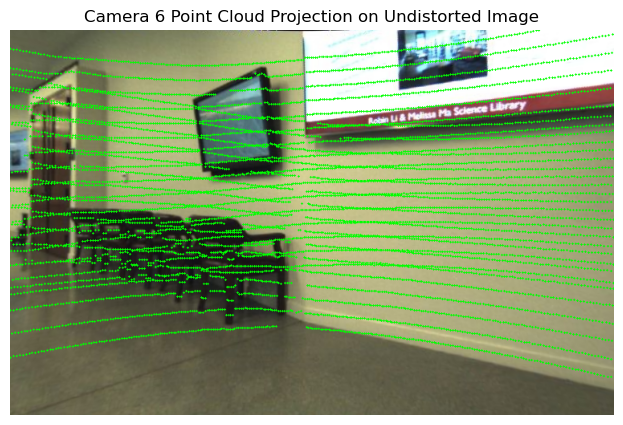

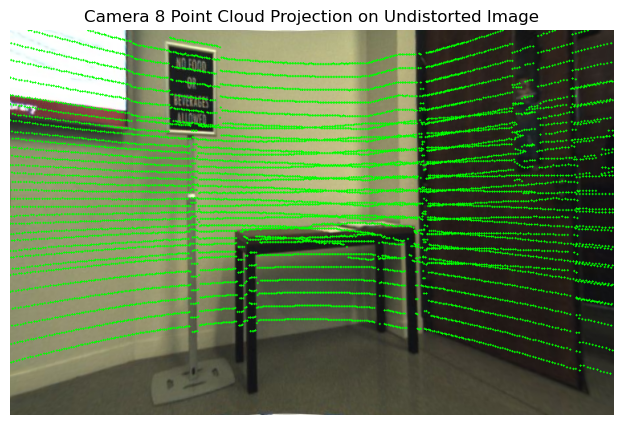

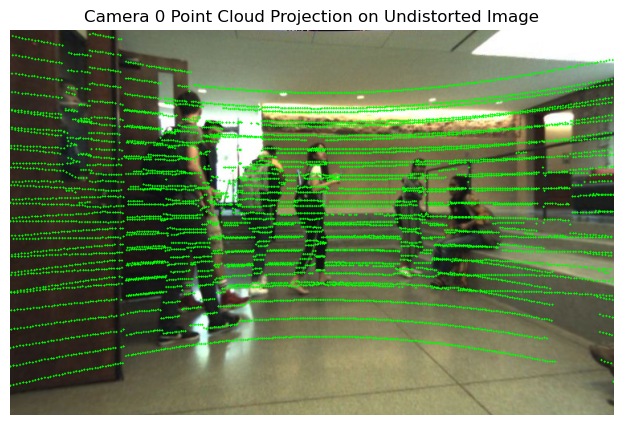

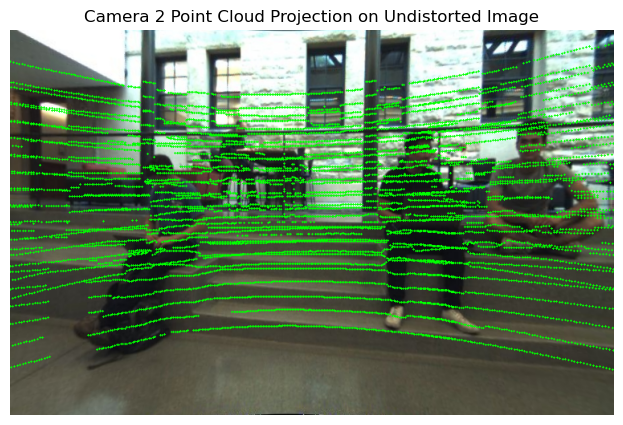

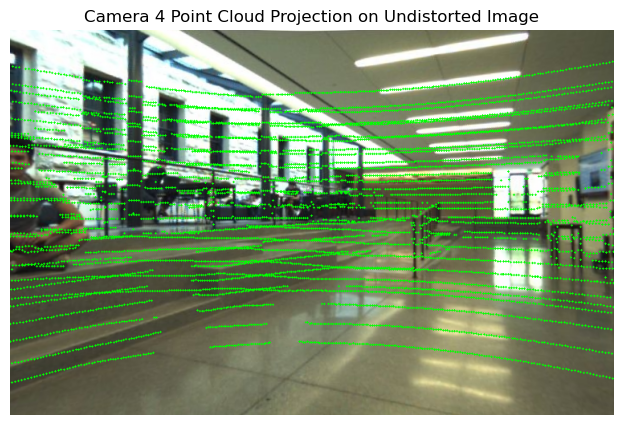

In [9]:
# Iterating over specified camera IDs to process and visualize point clouds on undistorted images.
for cam_id in [6, 8, 0, 2, 4]:
    # Retrieve calibration data for the current camera, including both distorted and undistorted intrinsic matrices.
    cam_calib = lidar_calib[f'sensor_{cam_id}']
    undistorted_K = np.array(cam_calib['undistorted_img_K']).reshape(3, 3)
    undistorted_K = np.hstack([undistorted_K, np.zeros((3, 1))])  # Homogenize the undistorted intrinsic matrix.
    distored_K = np.array(cam_calib['distorted_img_K']).reshape(3, 3)
    D = np.array(cam_calib['D'])  # Distortion coefficients.

    # Compute the transformation matrix from the LiDAR (upper) to the camera coordinate system and project the points.
    upper2ego = np.array(lidar_calib["lidar"]["upper2ego"])
    ego2cam = inv(np.array(cam_calib["cam2ego"]))
    pts_ref = ego2cam.dot(upper2ego.dot(merged_pcd.T)).T
    pts_ref = undistorted_K.dot(pts_ref.T).T  # Project points using the undistorted intrinsic matrix.
    pts_ref = pts_ref[pts_ref[:, 2] > 0]  # Keep only points in front of the camera.
    pts_ref = pts_ref[:, :2] / pts_ref[:, 2].reshape(-1, 1)  # Normalize points to the image plane.

    # Load the corresponding camera image, undistort it, and plot the projected points on this undistorted image.
    image = cv2.imread(join(data_dir, 'train_dataset_with_activity', 'images', f'image_{cam_id}', location, '000000.jpg'))
    undistorted_image, _ = undisort_image(image, distored_K, D)  # Undistort the image using its intrinsic matrix and distortion coefficients.

    # Draw each point on the undistorted image.
    for pts in pts_ref:
        x, y = pts
        if 0 <= x < undistorted_image.shape[1] and 0 <= y < undistorted_image.shape[0]:
            cv2.circle(undistorted_image, (int(x), int(y)), 1, (0, 255, 0), -1)

    # Display the undistorted image with projected points, enhancing visualization for applications like deep learning pipelines.
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB))  # Display the image in RGB format.
    plt.title(f'Camera {cam_id} Point Cloud Projection on Undistorted Image')
    plt.axis('off')  # Hide the axis for a cleaner view.
    plt.show()
